In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Data generation

Let's generate couple thousands of signals that belong to one of the following class:

- noise

- guassian

- sine gaussian

- scattered light

This type of signals are seen in the interferometer They either imitate astrophysical signal or contaminate data making the analysis a challenge.

In [2]:
# Gaussian signal
def generate_gaussian(fs=4096, noise_ampl=0.1):
    
    # Signal input parameters
    ampl = 1.0
    tau = np.random.uniform(0.0,0.5)
    t_0 = np.random.uniform(0.0,0.5)

    dt = float(1.0/fs)
    t = np.arange(-1, 1, dt)
    
    gauss = ampl * np.exp( -(t - t_0)**2 / (2.0*tau**2))
    noise = np.random.randn(fs*2)*noise_ampl
    
    return gauss + noise
        

In [3]:
# Sine-gaussian signal
def generate_sine_gaussian(fs=4096, noise_ampl=0.1):
    
    # Signal input parameters
    ampl = 1.0
    tau = np.random.uniform(0.0,0.5)
    t_0 = np.random.uniform(0.0,0.5)
    f_0 = np.random.uniform(5.0, 300.0)
    
    dt = float(1.0/fs)
    t = np.arange(-1, 1, dt)
    
    sgauss = ampl * np.sin(2.0 * np.pi * f_0 * (t-t_0) ) * np.exp( -(t - t_0)**2 / (2.0*tau**2) )
    noise = np.random.randn(fs*2)*noise_ampl
    
    return sgauss + noise

In [4]:
# Generate scattered light
def generate_scattered_light(fs=4096, noise_ampl=0.1):
    # Signal input parameters
    ampl = 1.0
    tau = np.random.uniform(0.0,0.5)
    t_0 = np.random.uniform(0.0,0.5)
    f_0 = np.random.uniform(5.0, 300.0)
    K = np.random.uniform(0.0,1.0)
    
    dt = float(1.0/fs)
    t = np.arange(-1, 1, dt)
    
    fi_sl = 2.0 * np.pi * f_0 * (t - t_0) * (1.0 - K * (t - t_0)**2)
    scatt = ampl * np.sin(fi_sl) * np.exp( -(t - t_0)**2 / (2.0*tau) )
    noise = np.random.randn(fs*2)*noise_ampl

    return scatt + noise

In [5]:
# Generate noise
def generate_noise(fs=4096):
    noise = np.random.randn(fs*2)
    return noise

# Let's generate 3000 signals that belong to each class

In [6]:
def create_dataset(n_per_class=3000, fs=4096):
    dataset = np.zeros((n_per_class*4, fs*2))
    labels = np.zeros((n_per_class*4,))
    for n in range(n_per_class):
        gauss = generate_gaussian()
        sgauss = generate_sine_gaussian()
        scatt = generate_scattered_light()
        noise = generate_noise()
        
        # Fill the dataset and labels
        dataset[4*n] = gauss
        labels[4*n] = 0
        
        dataset[4*n+1] = sgauss
        labels[4*n+1] = 1
        
        dataset[4*n+2] = scatt
        labels[4*n+2] = 2
        
        dataset[4*n+3] = noise
        labels[4*n+3] = 3
        
    return dataset, labels

In [7]:
dataset, labels = create_dataset()

# Let's shuffle the data to avoid potential problems with overfitting

There are many ways how to shuffle your high-dimensional dataset. However my favourite is permutation. It's quite fast and do not consume a lot of RAM. Our dataset is small. But for more realistic application, lack of memory might be a huge limitation!


In [8]:
permutation_ind = np.random.permutation(labels.shape[0])
dataset = dataset[permutation_ind]
labels = labels[permutation_ind]

In [9]:
labels[:100]

array([3., 2., 2., 2., 0., 2., 1., 0., 0., 0., 2., 2., 1., 1., 3., 3., 1.,
       0., 1., 3., 1., 0., 1., 3., 1., 1., 2., 2., 0., 1., 2., 0., 2., 3.,
       0., 3., 0., 1., 1., 1., 1., 3., 2., 2., 3., 1., 1., 3., 2., 3., 0.,
       0., 2., 0., 2., 2., 2., 0., 0., 2., 1., 1., 0., 0., 0., 0., 3., 0.,
       0., 2., 1., 2., 1., 2., 0., 2., 3., 1., 3., 2., 3., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 3., 2., 0., 0., 0., 3., 3., 2., 1., 2.])

In [10]:
fs = 4096
time = np.arange(0,2*fs)/fs - 1
plt.plot(time, dataset[1])
plt.xlabel("Time [s]")
plt.ylabel("Ampl")

Text(0, 0.5, 'Ampl')

# Let's save our time-series data into HDF5 file

In [11]:
# Create the file and open the stream
h5 = h5py.File("ts.h5", "w")

In [12]:
# Create structures inside the file to store our data
h5.create_dataset("inputs", dataset.shape, np.float32)
h5.create_dataset("targets", labels.shape, np.int8)

<HDF5 dataset "targets": shape (12000,), type "|i1">

In [13]:
# Save the data into those structures
h5["inputs"][...] = dataset
h5["targets"][...] = labels

In [14]:
# Close the stream to the file!
h5.close()

# Let's know make some spectrograms out of this time-series data

In [15]:
from scipy import signal
from matplotlib.colors import LogNorm

In [16]:
k, f_samp = 10, 4096
glitch=dataset[1]

plt.figure()
fp, tp, Sxxp = signal.spectrogram(glitch, window='hann',fs=f_samp, noverlap=99*f_samp//(k*100), nperseg=f_samp//k, nfft=f_samp//k)
log_sq_Sxxp = np.log(np.sqrt(Sxxp))
plt.pcolormesh(tp, fp, log_sq_Sxxp, cmap='viridis')
plt.ylabel('Frequency [Hz]'), plt.xlabel('Time [sec]')
v1, v2 = np.sqrt(Sxxp.min()), np.sqrt(Sxxp.max())
Log10scale=LogNorm(vmin=v1, vmax=v2)
plt.ylim([0,500])
plt.pcolormesh(tp, fp, log_sq_Sxxp, norm=Log10scale, cmap='viridis')
plt.colorbar() 

# Colored noise

The first dataset was basen on easy to analyse gaussian noise. However in reality you are more probable to work with non-gaussian noise like colored noise.

Belowe we present you an example of the noise characteristic for the Virgo interferometer.

Text(0.5, 1.0, 'Background noise of Virgo interferometer')

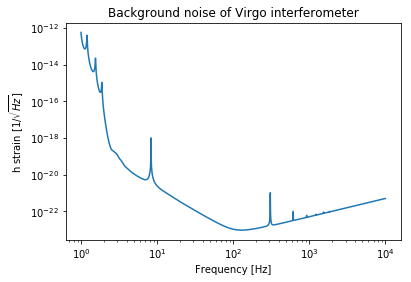

In [17]:
sensitivity = np.loadtxt("design_sensitivity.txt")
frequency = sensitivity[:,0]
strain = sensitivity[:,1]
plt.loglog(frequency, strain)
plt.xlabel("Frequency [Hz]")
plt.ylabel(r'h strain [1/$\sqrt{Hz}$]')
plt.title('Background noise of Virgo interferometer')

Now, let's create some time-series data using the colored noise

In [18]:
t = 2 # length of the data in seconds

In Virgo we are analysing the data only from particular range of frequencies where we expect to detect gravitational waves: 10 Hz to 1000 Hz. Let's filter out our frequency to this range.

In [19]:
frequency_range_ind = np.where((frequency>10) & (frequency<1000))
frequency_range = frequency[frequency_range_ind]
strain_range = strain[frequency_range_ind]

Text(0.5, 1.0, 'Background noise of Virgo interferometer limited to the range 10-1000 Hz')

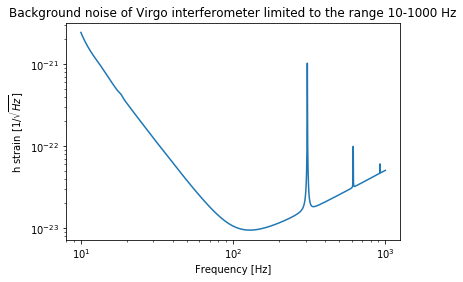

In [20]:
plt.loglog(frequency_range, strain_range)
plt.xlabel("Frequency [Hz]")
plt.ylabel(r'h strain [1/$\sqrt{Hz}$]')
plt.title('Background noise of Virgo interferometer limited to the range 10-1000 Hz')

### Let's now create some time-series!

In [21]:
n_points = fs*t
# equally spaced frequencies from f_min to f_nyqvist
freq = np.arange(0,n_points/2+1, dtype=float)/t   
# interpolate sensitivity curve at equally spaced frequencies
noise_interp = np.interp(freq, frequency_range, strain_range) 
# generate random phases for signal reconstruction, one for each f bin
phase = np.random.randn(np.shape(noise_interp)[0]) 

In [22]:
# Normalization
noise_f =  np.sqrt(t/2.)*fs *noise_interp * np.exp(2j*np.pi*phase)
noise_ts = np.fft.irfft(noise_f)

Text(0.5, 1.0, 'Colored noise time-series')

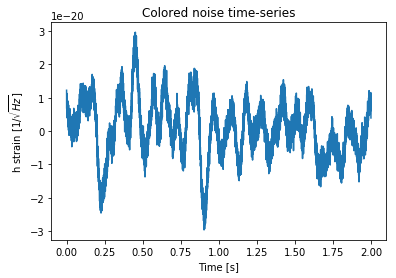

In [23]:
times = np.arange(0,fs*t)/fs
plt.plot(times, noise_ts)
plt.xlabel("Time [s]")
plt.ylabel(r'h strain [1/$\sqrt{Hz}$]')
plt.title("Colored noise time-series")

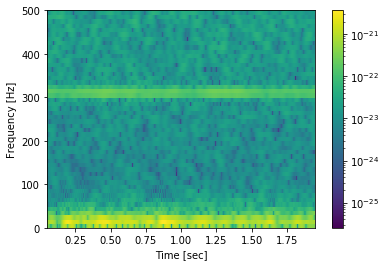

In [24]:
k, f_samp = 10, 4096
glitch=noise_ts

plt.figure()
fp, tp, Sxxp = signal.spectrogram(glitch, window='hann',fs=f_samp, noverlap=99*f_samp//(k*100), nperseg=f_samp//k, nfft=f_samp//k)
log_sq_Sxxp = np.log(np.sqrt(Sxxp))
plt.pcolormesh(tp, fp, log_sq_Sxxp, cmap='viridis')
plt.ylabel('Frequency [Hz]'), plt.xlabel('Time [sec]')
v1, v2 = np.sqrt(Sxxp.min()), np.sqrt(Sxxp.max())
Log10scale=LogNorm(vmin=v1, vmax=v2)
plt.ylim([0,500])
plt.pcolormesh(tp, fp, log_sq_Sxxp, norm=Log10scale, cmap='viridis')
plt.colorbar() 

Let's now create a method generating colored noise

In [25]:
def generate_colored_noise(frequency, strain, fs=4096, t=2):
    
    n_points = fs*t
    freq = np.arange(0,n_points/2+1, dtype=float)/t
    noise_interp = np.interp(freq, frequency, strain)
    phase = np.random.randn(np.shape(noise_interp)[0]) 
    noise_f =  np.sqrt(t/2.)*fs *noise_interp * np.exp(2j*np.pi*phase)
    noise_ts = np.fft.irfft(noise_f)
    
    noise_ts = noise_ts * 10**20 # rescale
    
    return noise_ts

In [26]:
# Generate scattered light
def generate_scattered_light_colored(fs=4096, noise_ampl=0.1, t=2):
    # Signal input parameters
    ampl = 1.0
    tau = np.random.uniform(0.0,0.5)
    t_0 = np.random.uniform(0.0,0.5)
    f_0 = np.random.uniform(5.0, 300.0)
    K = np.random.uniform(0.0,1.0)
    
    dt = float(1.0/fs)
    time = np.arange(-1, 1, dt)
    
    fi_sl = 2.0 * np.pi * f_0 * (time - t_0) * (1.0 - K * (time - t_0)**2)
    scatt = ampl * np.sin(fi_sl) * np.exp( -(time - t_0)**2 / (2.0*tau) )
    noise = generate_colored_noise(frequency_range, strain_range, fs=fs, t=t)

    return scatt + noise

In [31]:
scatt = generate_scattered_light_colored()

Text(0, 0.5, 'Ampl')

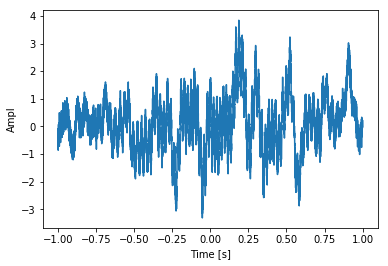

In [32]:
time = np.arange(0,2*4096)/4096 - 1
plt.plot(time, scatt)
plt.xlabel("Time [s]")
plt.ylabel("Ampl")

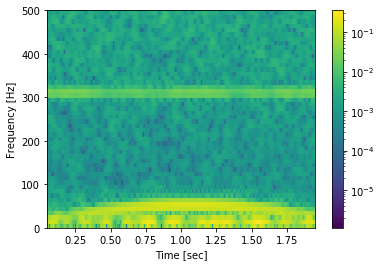

In [34]:
k, f_samp = 10, 4096
glitch=np.array(scatt, dtype=float)

plt.figure()
fp, tp, Sxxp = signal.spectrogram(glitch, window='hann',fs=f_samp, noverlap=99*f_samp//(k*100), nperseg=f_samp//k, nfft=f_samp//k)
log_sq_Sxxp = np.log(np.sqrt(Sxxp))
plt.pcolormesh(tp, fp, log_sq_Sxxp, cmap='viridis')
plt.ylabel('Frequency [Hz]'), plt.xlabel('Time [sec]')
v1, v2 = np.sqrt(Sxxp.min()), np.sqrt(Sxxp.max())
Log10scale=LogNorm(vmin=v1, vmax=v2)
plt.ylim([0,500])
plt.pcolormesh(tp, fp, log_sq_Sxxp, norm=Log10scale, cmap='viridis')
plt.colorbar() 

# Whitening

Many statistical analysis methods require white noise. That is why we need methods to whiten our colored noise.

In [35]:
#from statsmodels.regression.linear_model import GLSAR3
import statsmodels.api as sm

We need to create the whitening model and train it using longer dataset with colored noise. Let's try dataset with 300 seconds. 

In [36]:
colored_noise = generate_colored_noise(frequency_range, strain_range, fs=f_samp, t=300)

In [37]:
# We also need a time for the training
colored_time = np.arange(0,300*f_samp)/f_samp

Let's use GLSAR model (a regression model with an AR(p) covariance structure). 100 autoregressive parameters should be enough.

In [38]:
model = sm.GLSAR(colored_noise, colored_time, rho=100)

In [39]:
for i in range(20):
    results = model.fit()
    rho, sigma = sm.regression.yule_walker(results.resid, order=model.order)
    model = sm.GLSAR(colored_noise, colored_time, rho)

In [40]:
whitened_scatt = model.whiten(scatt)

# Voila!

Text(0, 0.5, 'Ampl')

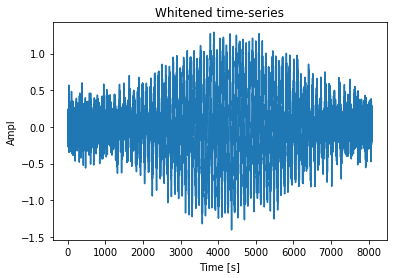

In [41]:
plt.plot(whitened_scatt)
plt.title("Whitened time-series")
plt.xlabel("Time [s]")
plt.ylabel("Ampl")

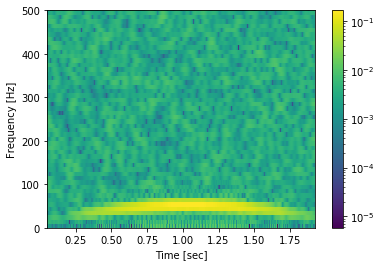

In [42]:
k, f_samp = 10, 4096
glitch=whitened_scatt

plt.figure()
fp, tp, Sxxp = signal.spectrogram(glitch, window='hann',fs=f_samp, noverlap=99*f_samp//(k*100), nperseg=f_samp//k, nfft=f_samp//k)
log_sq_Sxxp = np.log(np.sqrt(Sxxp))
plt.pcolormesh(tp, fp, log_sq_Sxxp, cmap='viridis')
plt.ylabel('Frequency [Hz]'), plt.xlabel('Time [sec]')
v1, v2 = np.sqrt(Sxxp.min()), np.sqrt(Sxxp.max())
Log10scale=LogNorm(vmin=v1, vmax=v2)
plt.ylim([0,500])
plt.pcolormesh(tp, fp, log_sq_Sxxp, norm=Log10scale, cmap='viridis')
plt.colorbar() 